In [101]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.formula.api as smf
import myforestplot as mfp
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import re

In [99]:
df = pd.read_csv('NPAR6.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,alcoholic,biliary,drug_induced,unspecified,mortality_7d,mortality_28d,mortality_90d,mortality_1y,has_kidney_disease,has_sepsis
0,19753686,29945708,30469520,2152-04-07T19:23:59,UNKNOWN,M,50,0,0,4.701343,...,0,1,1,1,0,0,0,0,0,0
1,10442603,23644640,31663173,2125-02-25T15:33:43,UNKNOWN,M,67,1,1,1.110764,...,1,0,0,1,1,1,1,1,0,1
2,15696172,21774504,36542183,2187-02-07T00:52:41,UNKNOWN,M,63,1,1,1.417917,...,0,0,0,1,1,1,1,1,0,1
3,19352969,21921993,34589708,2180-10-06T13:15:00,WHITE,F,67,1,1,1.496956,...,0,1,0,1,1,1,1,1,0,0
4,13734425,25179112,35877842,2132-09-06T09:00:00,WHITE,F,91,1,1,2.088681,...,0,1,0,1,1,1,1,1,0,0


In [100]:
races = {
    'UNKNOWN': 'Others',
    'UNABLE TO OBTAIN': 'Others',
    'ASIAN - CHINESE': 'Others',
    'ASIAN - SOUTH EAST ASIAN': 'Others',
    'ASIAN - ASIAN INDIAN': 'Others',
    'ASIAN - KOREAN': 'Others',
    'ASIAN': 'Others',
    'HISPANIC OR LATINO': 'Others',
    'HISPANIC/LATINO - PUERTO RICAN': 'Others',
    'HISPANIC/LATINO - GUATEMALAN': 'Others',
    'HISPANIC/LATINO - DOMINICAN': 'Others',
    'HISPANIC/LATINO - MEXICAN': 'Others',
    'HISPANIC/LATINO - SALVADORAN': 'Others',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Others',
    'HISPANIC/LATINO - CUBAN': 'Others',
    'HISPANIC/LATINO - COLUMBIAN': 'Others',
    'HISPANIC/LATINO - HONDURAN': 'Others',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Others',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Others',
    'MULTIPLE RACE/ETHNICITY': 'Others',
    'SOUTH AMERICAN': 'Others',
    'OTHER': 'Others',
    'PATIENT DECLINED TO ANSWER': 'Others',
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'PORTUGUESE': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/AFRICAN': 'Black',
}
df['race'] = df['race'].map(races)

In [121]:
df['age_group'] = df['age'].map(lambda v: 'age < 60' if v < 60 else 'age >= 60' )
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,has_sepsis,age_group,sepsis_group,has_kidney_disease_group,aki_group,severe_liver_disease_group,duration_7d,duration_28d,duration_90d,duration_1y
0,19753686,29945708,30469520,2152-04-07T19:23:59,Others,M,50,0,0,4.701343,...,0,age < 60,No,No,Yes,No,4.701343,4.701343,4.701343,4.701343
1,10442603,23644640,31663173,2125-02-25T15:33:43,Others,M,67,1,1,1.110764,...,1,age >= 60,Yes,No,No,No,1.110764,1.110764,1.110764,1.110764
2,15696172,21774504,36542183,2187-02-07T00:52:41,Others,M,63,1,1,1.417917,...,1,age >= 60,Yes,No,No,No,1.417917,1.417917,1.417917,1.417917
3,19352969,21921993,34589708,2180-10-06T13:15:00,White,F,67,1,1,1.496956,...,0,age >= 60,Yes,No,No,No,1.496956,1.496956,1.496956,1.496956
4,13734425,25179112,35877842,2132-09-06T09:00:00,White,F,91,1,1,2.088681,...,0,age >= 60,Yes,No,No,No,2.088681,2.088681,2.088681,2.088681


In [103]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'race', 'gender', 'age',
       'mortality_icu', 'mortality_hosp', 'los', 'hosp_los', 'icu_los',
       'admittime', 'dod', 'inr_max', 'pt_max', 'ptt_max',
       'abs_neutrophils_max', 'abs_lymphocytes_max', 'abs_monocytes_max',
       'glucose_max', 'hematocrit_max', 'wbc_max', 'aniongap_max',
       'creatinine_max', 'sodium_max', 'potassium_max', 'bilirubin_total_max',
       'neutrophis_max', 'bun_min', 'albumin_min', 'platelets_min',
       'bicarbonate_min', 'calcium_min', 'hemoglobin_min', 'ast_max',
       'alp_max', 'bun_max', 'chloride_max', 'rdw_max', 'hdl', 'ldl',
       'cholesterol', 'triglycerides', 'alt_max', 'total_protein_max',
       'amylase_max', 'lipase', 'NPAR', 'SII', 'NLR', 'PLR', 'LMR', 'NPR',
       'SIRI', 'sapsii', 'oasis', 'sofa', 'cci', 'apsiii', 'heart_rate_mean',
       'resp_rate_mean', 'mbp_mean', 'temperature_mean', 'spo2_mean',
       'myocardial_infarct', 'congestive_heart_failure',
       'cere

In [122]:
dic ={
    0: 'No',
    1: 'Yes'
}
cols = ['sepsis', 'has_kidney_disease', 'aki', 'severe_liver_disease']
for col in cols:
    df[col +'_group'] = df[col].map(dic)
df.head()

,subject_id,hadm_id,stay_id,intime,race,gender,age,mortality_icu,mortality_hosp,los,...,has_sepsis,age_group,sepsis_group,has_kidney_disease_group,aki_group,severe_liver_disease_group,duration_7d,duration_28d,duration_90d,duration_1y
0,19753686,29945708,30469520,2152-04-07T19:23:59,Others,M,50,0,0,4.701343,...,0,age < 60,No,No,Yes,No,4.701343,4.701343,4.701343,4.701343
1,10442603,23644640,31663173,2125-02-25T15:33:43,Others,M,67,1,1,1.110764,...,1,age >= 60,Yes,No,No,No,1.110764,1.110764,1.110764,1.110764
2,15696172,21774504,36542183,2187-02-07T00:52:41,Others,M,63,1,1,1.417917,...,1,age >= 60,Yes,No,No,No,1.417917,1.417917,1.417917,1.417917
3,19352969,21921993,34589708,2180-10-06T13:15:00,White,F,67,1,1,1.496956,...,0,age >= 60,Yes,No,No,No,1.496956,1.496956,1.496956,1.496956
4,13734425,25179112,35877842,2132-09-06T09:00:00,White,F,91,1,1,2.088681,...,0,age >= 60,Yes,No,No,No,2.088681,2.088681,2.088681,2.088681


In [123]:
df['duration_7d'] = np.where((df['mortality_7d'] == 0) & (df['los'] > 7), 7, df['los'])
df['duration_28d'] = np.where((df['mortality_28d'] == 0) & (df['los'] > 28), 28, df['los'])
df['duration_90d'] = np.where((df['mortality_90d'] == 0) & (df['los'] > 90), 90, df['los'])
df['duration_1y']  = np.where((df['mortality_1y']  == 0) & (df['los'] > 365), 365, df['los'])

In [126]:
cph = CoxPHFitter()
formular = 'race+ gender + age_group + sepsis_group + has_kidney_disease_group + aki_group + severe_liver_disease_group'
model = cph.fit(df=df, duration_col = 'duration_28d', event_col = 'mortality_28d', formula = formular)
res = model.summary

In [127]:
def split_parts(text):
    pattern = r"^(\w+)\[([A-Z])\.(.+)\]$"
    match = re.match(pattern, text)
    
    if match:
        return match.groups()
    print(text)
    return text


In [142]:
results = []
durations = ['duration_7d', 'duration_28d', 'duration_90d', 'duration_1y']
mortalities = ['mortality_7d', 'mortality_28d', 'mortality_90d', 'mortality_1y']
cph = CoxPHFitter()
formular = 'race + gender + age_group + sepsis_group + has_kidney_disease_group + aki_group + severe_liver_disease_group + NPAR'
for i in range(len(durations)):
    model = cph.fit(df = df, duration_col = durations[i], event_col = mortalities[i], formula = formular)
    res = model.summary
    for text in res.index[:-1]:
        name, _, item = split_parts(text)
        risk = res.loc[text, 'exp(coef)']
        ll = res.loc[text, 'exp(coef) lower 95%']
        lh = res.loc[text, 'exp(coef) upper 95%']
        results.append({
            'category': name,
            'item': item,
            0: ll,
            1: lh,
            'risk': risk,
            'nobs': df[df[name] == item][durations[i]].count(),
            'pvalues': res.loc[text, 'p'],
            'risk_pretty': f'{risk:.2f} ({ll:.2f}, {lh:.2f})',
            'strf': durations[i],
            # 'risk_only': '<0.001' if res.loc[text, 'p'] < 0.001 else f'{res.loc[text, "p"]:.3f}'
            'risk_only': round(risk, 2)
        })

df_res = pd.DataFrame(results)
df_res.head()


,category,item,0,1,risk,nobs,pvalues,risk_pretty,strf,risk_only
0,race,Others,0.339660,20.650240,2.648407,180,0.352644,"2.65 (0.34, 20.65)",duration_7d,2.65
1,race,White,0.417059,23.303938,3.117548,386,0.267916,"3.12 (0.42, 23.30)",duration_7d,3.12
2,gender,M,0.635073,2.390350,1.232090,357,0.537070,"1.23 (0.64, 2.39)",duration_7d,1.23
3,age_group,age >= 60,1.638530,7.891417,3.595876,282,0.001416,"3.60 (1.64, 7.89)",duration_7d,3.60
4,sepsis_group,Yes,0.673976,2.764405,1.364970,346,0.387519,"1.36 (0.67, 2.76)",duration_7d,1.36


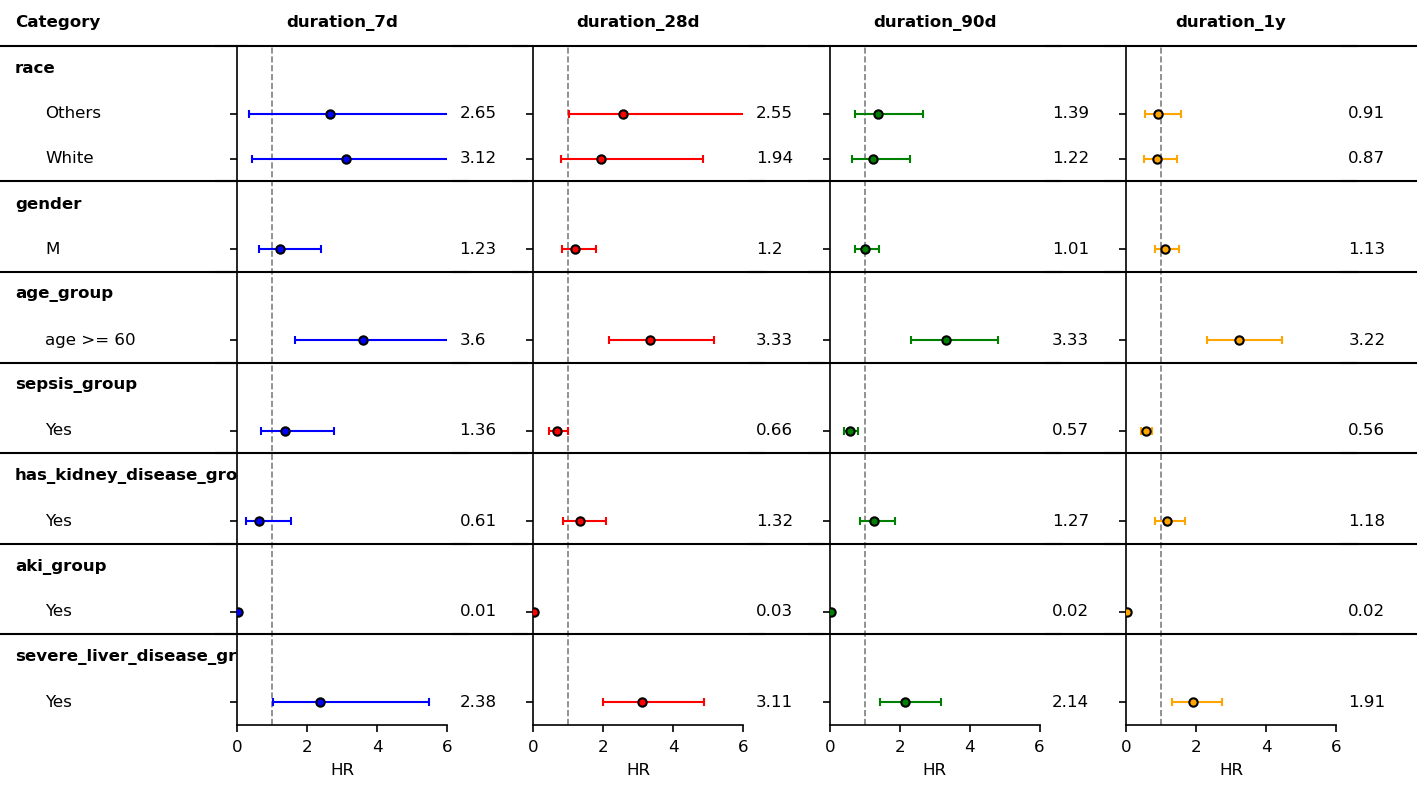

In [145]:
plt.rcParams["font.size"] = 8
errorbar_kwds = dict(capsize=2,  lw=1, markersize=4)
ref_kwds = dict(s=13)

fp = mfp.ForestPlot(ratio=(3,3,1,3,1,3,1, 3, 1),
                    fig_ax_index=[2,4,6, 8],
                    figsize=(12,6),
                    dpi=150,
                    df=df_res[df_res['strf'] == 'duration_7d'],
                    vertical_align=True,
                    yticks_show=True,
                    hide_spines=["top", "right"],
                    )
order = durations
fp.h_multi_errorbar(
    df=df_res,
    by="strf",
    order = order,
    multi_kwds=dict(
        errorbar_color=["blue", "red", "green", "orange"],
        ref_color=["blue", "red", "green", "orange"],
    ),
    errorbar_kwds=errorbar_kwds,
    ref_kwds=ref_kwds,
)
fp.ax_method_to_figs("set_xlim", [0.0, 6])
fp.ax_method_to_figs("set_xlabel", "HR")
fp.ax_method_to_figs("axvline",
                     x=1, ymin=0, ymax=1.0,
                     color="black", alpha=0.5,
                     ls="--", lw=0.8)

for ax_ind, title in zip([2,4,6, 8], order):
    ax = fp.axd[ax_ind]
    xmin, xmax = ax.get_xlim()
    ax.text((xmax + xmin)/2, 1.0, title,
            ha="center", va="center",
            fontweight="bold")

fp.axd[1].set_xlim([0.65, 1])
fp.embed_cate_strings(1,"category", 0.65, header="Category",
                      text_kwds=dict(fontweight="bold"),
                      header_kwds=dict(fontweight="bold")
                      )
fp.embed_strings(1, "item", 0.7, header="", replace={"age":""})
fp.h_multi_embed_strings([3, 5, 7, 9], "risk_only", 0.0,
                         df=df_res, by="strf", order=order)
fp.horizontal_variable_separators()
plt.show()

In [ ]:
results = []
for text in res.index[:-1]:
    name, _, item = split_parts(text)
    risk = res.loc[text, 'exp(coef)']
    ll = res.loc[text, 'exp(coef) lower 95%']
    lh = res.loc[text, 'exp(coef) upper 95%']
    results.append({
        'category': name,
        'item': item,
        0: ll,
        1: lh,
        'risk': risk,
        'nobs': df[df[name]== item]['mortality_28d'].count(),
        'pvalues': res.loc[text, 'p'],
        'risk_pretty': f'{risk:.2f} ({ll:.2f}), {lh:.2f}' 
    })
df_res = pd.DataFrame(results)
df_res.head()

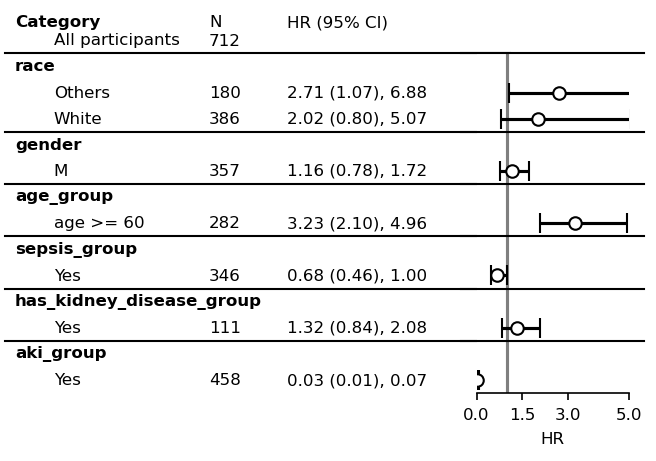

In [131]:
plt.rcParams["font.size"] = 8
fp = mfp.SimpleForestPlot(ratio=(8,3), dpi=150, figsize=(5,3),
                        df=df_res, vertical_align=True)
fp.errorbar(errorbar_kwds=None)
fp.ax2.set_xlim([0, 0.6])
fp.ax2.set_xticks([0, 1.5, 3, 5])
fp.ax2.set_xlabel("HR")
fp.ax2.axvline(x=1, ymin=0, ymax=1.0, color="black", alpha=0.5)

fp.ax1.set_xlim([0.35, 1])
y_header=1.7
fp.embed_cate_strings("category", 0.30, header="Category",
                 text_kwds=dict(fontweight="bold"),
                 header_kwds=dict(fontweight="bold"),
                 y_header=y_header
                 )
fp.embed_strings("item", 0.36, header="All participants", replace={"age":""})
fp.embed_strings("nobs", 0.60, header="N", y_header=y_header)
fp.ax1.text(0.60, 0.8, "712")
fp.embed_strings("risk_pretty", 0.72, header="HR (95% CI)", y_header=y_header)
fp.horizontal_variable_separators()
plt.show()

code mẫu 

In [83]:
# pip install myforestplot

In [84]:
df = pd.read_csv('titanic.csv', usecols= ["survived", "pclass", "sex", "age", "embark_town", "class"])
df.head()

,survived,pclass,sex,age,class,embark_town
0,0,3,male,22.0,Third,Southampton
1,1,1,female,38.0,First,Cherbourg
2,1,3,female,26.0,Third,Southampton
3,1,1,female,35.0,First,Southampton
4,0,3,male,35.0,Third,Southampton


In [85]:
encoder = OrdinalEncoder()
df[['sex', 'embark_town']] = encoder.fit_transform(df[['sex', 'embark_town']])

In [86]:
imp = IterativeImputer(initial_strategy = 'most_frequent')
cols = ['survived', 'pclass', 'age', 'embark_town']
df[cols] = imp.fit_transform(df[cols])

In [87]:
df[['sex', 'embark_town']] = encoder.inverse_transform(df[['sex', 'embark_town']])

In [88]:
df.isna().sum()

survived       0
pclass         0
sex            0
age            0
class          0
embark_town    0
dtype: int64

In [89]:
df['age'] = df['age'].map(lambda v: '0_19' if v < 20 else '20_39' if v < 40 else '40 or more')

In [90]:
df.dtypes

survived       float64
pclass         float64
sex             object
age             object
class           object
embark_town     object
dtype: object

In [91]:
res = smf.logit(formula= 'survived ~ pclass + age + sex + embark_town', data = df).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.429911
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      884
Method:                           MLE   Df Model:                            6
Date:                Sun, 28 Sep 2025   Pseudo R-squ.:                  0.3544
Time:                        10:12:32   Log-Likelihood:                -383.05
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.063e-87
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      5.5243      0.461     11.983      0.000       4.621       6.428
age[T.20_39]                  -1.2815      0.228     -5.611      0.000      -1.729      -0.834
age[T.40 or more]             -2.1338      0.312     -6.838      0.000      -2.745      -1.522
sex[T.male]                   -2.5601      0.194    -13.228      0.000      -2.939      -2.181
embark_town[T.Queenstown]     -0.2812      0.393     -0.715      0.475      -1.052       0.490
embark_town[T.Southampton]    -0.4570      0.236     -1.936      0.053      -0.920       0.006
pclass                        -1.3096      0.134     -9.763      0.000      -1.573      -1.047
==============================================================================================
"""

In [92]:
np.exp(res.params)

Intercept                     250.699671
age[T.20_39]                    0.277629
age[T.40 or more]               0.118386
sex[T.male]                     0.077300
embark_town[T.Queenstown]       0.754888
embark_town[T.Southampton]      0.633207
pclass                          0.269920
dtype: float64

In [93]:
np.exp(res.conf_int())

,0,1
Intercept,101.567923,618.800927
age[T.20_39],0.177445,0.434376
age[T.40 or more],0.064223,0.218228
sex[T.male],0.052899,0.112959
embark_town[T.Queenstown],0.349118,1.632274
embark_town[T.Southampton],0.398670,1.005723
pclass,0.207516,0.351090


In [94]:
res = smf.logit(formula = 'survived ~ pclass + age + sex + embark_town', data=df).fit()
order = ["age", "sex", "embark_town"]
cont_cols = []
item_order = {"embark_town": ['Southampton', 'Cherbourg', 'Queenstown'],
              "age": ["0_19", "20_39", "40 or more"]
             }

df_res = mfp.statsmodels_pretty_result_dataframe(df, res,
            order=order,
            cont_cols=cont_cols,
            item_order=item_order,
            fml=".3f",
        )

df_res.head(2)


Optimization terminated successfully.
         Current function value: 0.429911
         Iterations 6


C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\myforestplot\cleaning_utils.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'age' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[ind, cate] = s1
C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\myforestplot\cleaning_utils.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfM = dfM.sort_values(by="item",key=lambda x: x.replace(sort_dic))


,category,item,0,1,risk,pvalues,nobs,risk_pretty
0,age,20_39,0.177445,0.434376,0.277629,2.011488e-08,NaN,"0.28 (0.18, 0.43)"
1,age,40 or more,0.064223,0.218228,0.118386,8.017312e-12,NaN,"0.12 (0.06, 0.22)"


In [95]:
df_res = pd.DataFrame()
for item in ["First", "Second", "Third"]:
    dataM = df[df["class"] == item]
    res = smf.logit("survived ~ sex + age + embark_town", data=dataM).fit()

    order = ["age", "sex", "embark_town"]
    cont_cols = []
    item_order = {"embark_town": ['Southampton', 'Cherbourg', 'Queenstown'],
                  "age": ["0_19", "20_39", "40 or more"]
                 }

    dfM = mfp.statsmodels_pretty_result_dataframe(dataM, res,
                order=order,
                cont_cols=cont_cols,
                item_order=item_order,
                fml=".3f",
            )

    dfM["strf"] = item
    df_res = pd.concat((df_res, dfM))

df_res.head()


Optimization terminated successfully.
         Current function value: 0.398124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.307969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436168
         Iterations 7


C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\myforestplot\cleaning_utils.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'sex' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[ind, cate] = s1
C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\myforestplot\cleaning_utils.py:133: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfM = dfM.sort_values(by="item",key=lambda x: x.replace(sort_dic))
C:\Users\nam09\AppData\Roaming\Python\Python312\site-packages\myforestplot\cleaning_utils.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of p

,category,item,0,1,risk,pvalues,nobs,risk_pretty,strf
0,age,20_39,0.315925,6.157752,1.394771,6.605481e-01,NaN,"1.39 (0.32, 6.16)",First
1,age,40 or more,0.075683,1.428288,0.328782,1.377308e-01,NaN,"0.33 (0.08, 1.43)",First
12,sex,male,0.006119,0.073550,0.021214,1.247298e-09,NaN,"0.02 (0.01, 0.07)",First
11,embark_town,Southampton,0.376511,1.766074,0.815442,6.048377e-01,NaN,"0.82 (0.38, 1.77)",First
10,embark_town,Queenstown,0.011765,24.637850,0.538398,7.509472e-01,NaN,"0.54 (0.01, 24.64)",First


In [96]:
df_res["risk_only"] = df_res["risk"].apply(lambda x : f"{x:.2f}")
df_res.head()

,category,item,0,1,risk,pvalues,nobs,risk_pretty,strf,risk_only
0,age,20_39,0.315925,6.157752,1.394771,6.605481e-01,NaN,"1.39 (0.32, 6.16)",First,1.39
1,age,40 or more,0.075683,1.428288,0.328782,1.377308e-01,NaN,"0.33 (0.08, 1.43)",First,0.33
12,sex,male,0.006119,0.073550,0.021214,1.247298e-09,NaN,"0.02 (0.01, 0.07)",First,0.02
11,embark_town,Southampton,0.376511,1.766074,0.815442,6.048377e-01,NaN,"0.82 (0.38, 1.77)",First,0.82
10,embark_town,Queenstown,0.011765,24.637850,0.538398,7.509472e-01,NaN,"0.54 (0.01, 24.64)",First,0.54


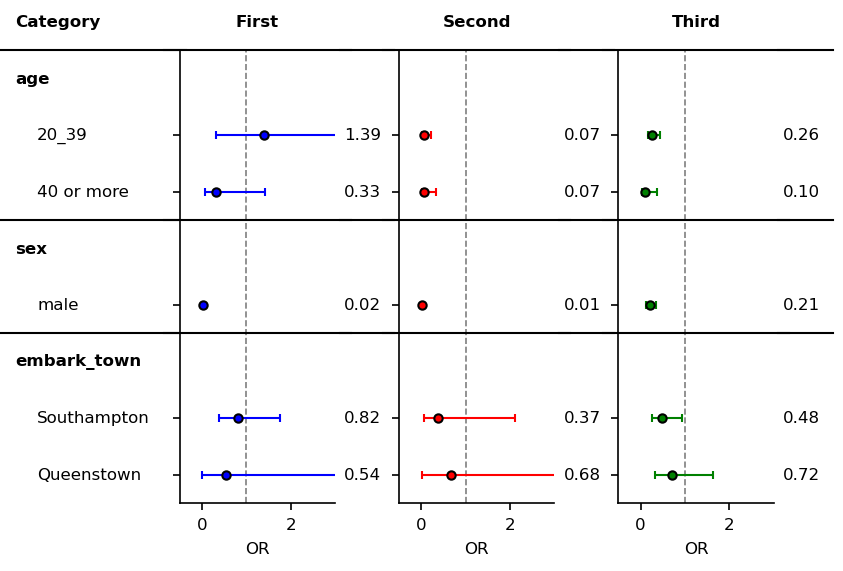

In [97]:
plt.rcParams["font.size"] = 8
errorbar_kwds = dict(capsize=2, lw=1, markersize=4)
ref_kwds = dict(s=13)

fp = mfp.ForestPlot(ratio=(3,3,1,3,1,3,1), fig_ax_index=[2,4,6], figsize=(7,4), dpi=150, df=df_res[df_res['strf'] == 'First'],
    vertical_align=True, yticks_show=True, hide_spines=["top", "right"])
order = ["First", "Second", "Third"]
fp.h_multi_errorbar(
    df=df_res,
    by="strf",
    order=order,
    multi_kwds=dict(
        errorbar_color=["blue", "red", "green"],
        ref_color=["blue", "red", "green"],
    ),
    errorbar_kwds=errorbar_kwds,
    ref_kwds=ref_kwds,
)

fp.ax_method_to_figs("set_xlim", [-0.5, 3])
fp.ax_method_to_figs("set_xlabel", "OR")
fp.ax_method_to_figs("axvline", x=1, ymin=0, ymax=1.0, color="black", alpha=0.5, ls="--", lw=0.8)

for ax_ind, title in zip([2,4,6], order):
    ax = fp.axd[ax_ind]
    xmin, xmax = ax.get_xlim()
    ax.text((xmax + xmin)/2, 1.0, title, ha="center", va="center", fontweight="bold")

fp.axd[1].set_xlim([0.65, 1])
fp.embed_cate_strings(1, "category", 0.65, header="Category", text_kwds=dict(fontweight="bold"), header_kwds=dict(fontweight="bold"))
fp.embed_strings(1, "item", 0.7, header="", replace={"age":""})
fp.h_multi_embed_strings([3, 5, 7], "risk_only", 0.0, df=df_res, by="strf", order=order)
fp.horizontal_variable_separators()
plt.show()
